In [7]:
import numpy as np
import pandas as pd
import scipy as sp


%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = 16, 12
plt.rcParams['lines.linewidth'] = 1.5

font = {'weight' : 'normal',
      'size'   : 12}

plt.rc('font', **font)

import fair
from fair.fair_inverse_model import co2_conc_total as rf_to_conc
from fair.fair_inverse_model import annual_emissions_calc2 as conc_to_emissions
from fair.forward import fair_scm as FAIR_model
fair.__version__

'1.0.1'

In [8]:
# Using Fair to go RCP3PD emissions -> radiative forcings for CH4 and CO2

emms_file = './fair/RCPs/RCP3PD_EMISSIONS.csv'
emms_data = np.genfromtxt(emms_file,skip_header=36,delimiter=',',names=True)

emissions = emms_data['FossilCO2'] + emms_data['OtherCO2']
M_emissions = emms_data['CH4']

concs_filem = './fair/GCP_data/RCP3PD_MIDYEAR_CONCENTRATIONS.csv'
concs_datam = np.genfromtxt(concs_filem,skip_header=37,delimiter=',',names=True)
M_concs = concs_datam['CH4']
N_concs = concs_datam['N2O']
concs = concs_datam['CO2']

forc_file = './fair/RCPs/RCP3PD_MIDYEAR_RADFORCING.csv'
forc_data = np.genfromtxt(forc_file,skip_header=58,delimiter=',',names=True)
other_rf = forc_data['TOTAL_ANTHRO_RF'] - forc_data['CO2_RF'] - forc_data['CH4_RF']

C,T,RF,M,N,MK_gas,db,tau_M,tau_N = FAIR_model(emissions=emissions,M_emissions=M_emissions,
                            other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.0316, tau_M_0 = 9.0)

C_minus_CH4,T_minus_CH4,RF_minus_CH4,M_minus_CH4,N_minus_CH4,MK_gas_minus_CH4,db_minus_CH4,tau_M_minus_CH4,tau_N_minus_CH4 = FAIR_model(
                            emissions=emissions,
                            other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.0316, tau_M_0 = 9.0)

C_minus_CO2,T_minus_CO2,RF_minus_CO2,M_minus_CO2,N_minus_CO2,MK_gas_minus_CO2,db_minus_CO2,tau_M_minus_CO2,tau_N_minus_CO2 = FAIR_model(
                            emissions = np.zeros(len(other_rf)), M_emissions=M_emissions, other_rf=other_rf,
                            N_0=270.0,MAGICC_model = True,S_OH_CH4 = -0.32, S_T_CH4 = 0.0316, tau_M_0 = 9.0)
    
C_0,T_0,RF_0,M_0,N_0,MK_gas_0,db_0,tau_M_0,tau_N_0 = FAIR_model(other_rf=forc_data['TOTAL_ANTHRO_RF'],
                            N_0=270.0,MAGICC_model = True,S_OH_CH4 = -0.32, S_T_CH4 = 0.0316, tau_M_0 = 9.0)

ANTHRO_RF = RF

# NB. the "0" signifier represents radiative forcings entirely NOT calculated by fair (ie. from RCP only)
ANTHRO_RF_0 = RF_0

In [9]:
# Radiative forcings -> Concentrations

ANTHRO_conc = rf_to_conc(ANTHRO_RF)
ANTHRO_minus_CH4_conc = rf_to_conc(RF_minus_CH4)
ANTHRO_minus_CO2_conc = rf_to_conc(RF_minus_CO2)

ANTHRO_conc_0 = rf_to_conc(ANTHRO_RF_0)

In [10]:
# Concentrations -> Emissions

ANTHRO_emms = conc_to_emissions(ANTHRO_conc,T,year_smoothing=5) * 44./12.
ANTHRO_minus_CH4_emms = conc_to_emissions(ANTHRO_minus_CH4_conc,T_minus_CH4,year_smoothing=5) * 44./12.
ANTHRO_minus_CO2_emms = conc_to_emissions(ANTHRO_minus_CO2_conc,T_minus_CO2,year_smoothing=5) * 44./12.

ANTHRO_emms_0 = conc_to_emissions(ANTHRO_conc_0,T_0,year_smoothing=5) * 44./12.

CO2_CO2_fe_emms = ANTHRO_emms - ANTHRO_minus_CO2_emms
CH4_CO2_fe_emms = ANTHRO_emms - ANTHRO_minus_CH4_emms
anthro_CO2_fe_emms = ANTHRO_emms
other_CO2_fe_emms = anthro_CO2_fe_emms - CH4_CO2_fe_emms - CO2_CO2_fe_emms

anthro_CO2_fe_emms_0 = ANTHRO_emms_0


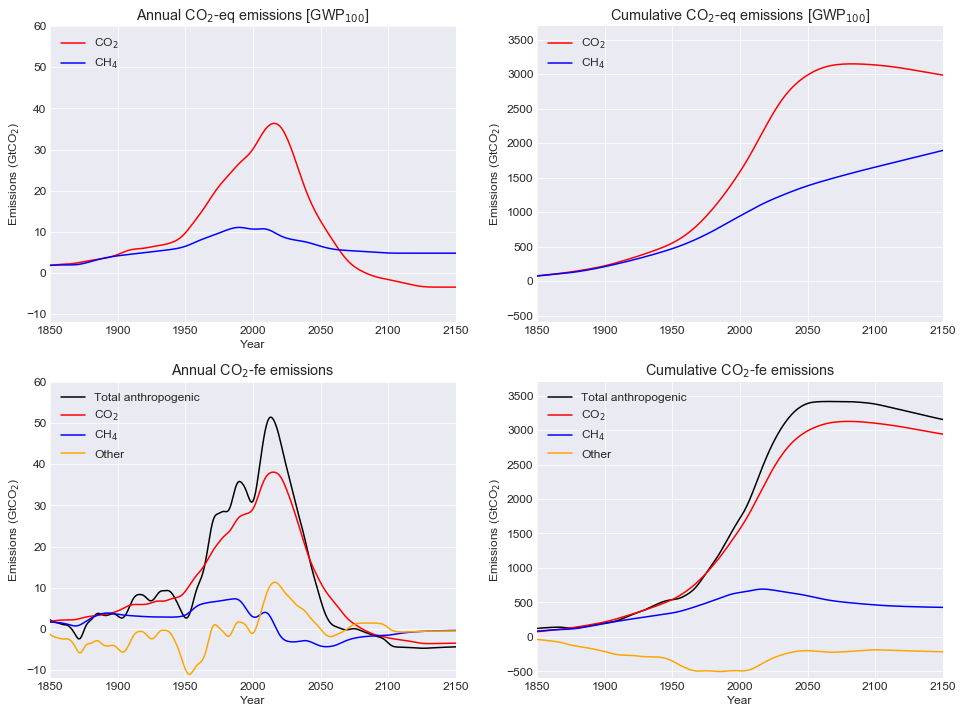

In [11]:
from scipy.ndimage.filters import gaussian_filter as smooth

time = np.arange(1765,2501)
CO2_emissions = emissions * 44./12.
CH4_CO2_eq_GWP = M_emissions * 34./1000.

cum_CO2_fe = np.cumsum(CO2_CO2_fe_emms)
cum_CH4_fe = np.cumsum(CH4_CO2_fe_emms)
cum_anthro_fe = np.cumsum(anthro_CO2_fe_emms)
cum_other_fe = np.cumsum(other_CO2_fe_emms)

cum_anthro_fe_0 = np.cumsum(anthro_CO2_fe_emms_0)

# Smoothing

CO2_emissions_smooth = smooth(CO2_emissions,5)
CH4_CO2_eq_GWP_smooth = smooth(CH4_CO2_eq_GWP,5)
cum_CO2_emms_GWP = np.cumsum(CO2_emissions_smooth)
cum_CH4_emms_GWP = np.cumsum(CH4_CO2_eq_GWP_smooth)

fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

#total_0 = CO2_emissions_smooth + CH4_CO2_eq_GWP_smooth
#cum_total_0 = np.cumsum(total_0)

#ax1.plot(time,total_0,label='CO$_2$ + MH$_4$',color='black')
ax1.plot(time,CO2_emissions_smooth,label='CO$_2$',color='red')
ax1.plot(time,CH4_CO2_eq_GWP_smooth,label='CH$_4$',color='blue')
ax1.set_xlabel('Year')
ax1.set_ylabel('Emissions (GtCO$_2$)')
ax1.set_title('Annual CO$_2$-eq emissions [GWP$_{100}$]')
ax1.legend(loc='upper left')
ax1.set_xlim(1850,2150)
ax1.set_ylim(-12.,60.)

#ax2.plot(time,cum_total_0,label='CO$_2$ + MH$_4$',color='black')
ax2.plot(time,cum_CO2_emms_GWP,label='CO$_2$',color='red')
ax2.plot(time,cum_CH4_emms_GWP,label='CH$_4$',color='blue')
#ax2.set_xlabel('Year')
ax2.set_ylabel('Emissions (GtCO$_2$)')
ax2.set_title('Cumulative CO$_2$-eq emissions [GWP$_{100}$]')
ax2.legend(loc='upper left')
ax2.set_xlim(1850,2150)
ax2.set_ylim(-600.,3700)

#ax3.plot(time,anthro_CO2_fe_emms_0,'-.',label='Anthro_0',color='black')
ax3.plot(time,anthro_CO2_fe_emms,label='Total anthropogenic',color='black')
ax3.plot(time,CO2_CO2_fe_emms,label='CO$_2$',color='red')
ax3.plot(time,CH4_CO2_fe_emms,label='CH$_4$',color='blue')
ax3.plot(time,other_CO2_fe_emms,label='Other',color='orange')
ax3.set_xlabel('Year')
ax3.set_ylabel('Emissions (GtCO$_2$)')
ax3.set_title('Annual CO$_2$-fe emissions')
ax3.legend(loc='upper left')
ax3.set_xlim(1850,2150)
ax3.set_ylim(-12.,60.)

#ax4.plot(time,cum_anthro_fe_0,'-.',label='Anthro_0',color='black')
ax4.plot(time,cum_anthro_fe,label='Total anthropogenic',color='black')
ax4.plot(time,cum_CO2_fe,label='CO$_2$',color='red')
ax4.plot(time,cum_CH4_fe,label='CH$_4$',color='blue')
ax4.plot(time,cum_other_fe,label='Other',color='orange')
ax4.set_xlabel('Year')
ax4.set_ylabel('Emissions (GtCO$_2$)')
ax4.set_title('Cumulative CO$_2$-fe emissions')
ax4.legend(loc='upper left')
ax4.set_xlim(1850,2150)
ax4.set_ylim(-600.,3700)

fig.savefig('CO2-e (GWP100) vs CO2-fe figure')

#ANTHRO - from RCP3 RF data, total anthropogenic emissions calculated by fair inverse model.
#TOTAL - using fair forward co2 and ch4 data, and rcp everything else
#CO2 - co2 emissions calculated forwards from emissions to RF data, and backwards in fair inverse model
#CH4 - ch4 plus co2 emissions calculated from sums of RF calculated using fair forwards and emissions data, then differencing with 
        #just co2 to get methane contribution to emissions (co2-fe)
#OTHER - anthro rf data set from RCP3 minus co2 and ch4 from RCP3 data plus our calculated co2 rf. We then find emissions for this 
        #and remove the contribution from the co2 emissions calculated, and hence find contribution jsut due to other emissions